In [1]:
import matplotlib as mpl
import mpld3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
mpl.rc('figure',  figsize=(10, 6))
import functions as f
import sklearn.cluster as cl
import time
import easygui as gui
import hdbscan
from scipy.optimize import linear_sum_assignment
from hungarian_algorithm import algorithm

PATH = gui.fileopenbox(default='/media/erick/NuevoVol/LINUX_LAP/PhD/')

In [10]:
DF = pd.read_csv(PATH, index_col=0)
DF.index = np.arange(len(DF))
D = DF.values
DF

,X,Y,Z,I_FS,I_GS,FRAME
0,482.0,188.0,68.0,1.031259,0.001174,0.0
1,427.0,360.0,96.0,1.004936,0.001176,0.0
2,403.0,213.0,142.0,1.032614,0.001323,0.0
3,371.0,205.0,134.0,1.018975,0.000885,0.0
4,362.0,102.0,62.0,0.992206,0.001579,0.0
...,...,...,...,...,...,...
46637,109.0,310.0,98.0,1.025431,0.001729,2000.0
46638,64.0,450.0,102.0,1.019911,0.001073,2000.0
46639,56.0,355.0,117.0,1.008430,0.001126,2000.0
46640,34.0,363.0,93.0,1.024958,0.001173,2000.0


In [3]:
#%% K-Means for track detection
kmeans = cl.KMeans(n_clusters=D[D[:, 5] == 0].shape[0], init='k-means++').fit(DF[['X', 'Y', 'Z']])
DF['PARTICLE'] = kmeans.labels_
LINKED = DF
LINKED

,X,Y,Z,I_FS,I_GS,FRAME,PARTICLE
0,482.0,188.0,68.0,1.031259,0.001174,0.0,28
1,427.0,360.0,96.0,1.004936,0.001176,0.0,17
2,403.0,213.0,142.0,1.032614,0.001323,0.0,28
3,371.0,205.0,134.0,1.018975,0.000885,0.0,21
4,362.0,102.0,62.0,0.992206,0.001579,0.0,29
...,...,...,...,...,...,...,...
46637,109.0,310.0,98.0,1.025431,0.001729,2000.0,11
46638,64.0,450.0,102.0,1.019911,0.001073,2000.0,30
46639,56.0,355.0,117.0,1.008430,0.001126,2000.0,25
46640,34.0,363.0,93.0,1.024958,0.001173,2000.0,25


In [4]:
#%% Density Based Spatial Clustering (DBSC)
DBSCAN = cl.DBSCAN(eps=5, min_samples=8).fit(DF[['X', 'Y', 'Z']])
DF['PARTICLE'] = DBSCAN.labels_
LINKED = DF
L = LINKED.drop(np.where(LINKED.PARTICLE.values == -1)[0])
L

,X,Y,Z,I_FS,I_GS,FRAME,PARTICLE
0,482.0,188.0,68.0,1.031259,0.001174,0.0,19
1,427.0,360.0,96.0,1.004936,0.001176,0.0,0
2,403.0,213.0,142.0,1.032614,0.001323,0.0,22
3,371.0,205.0,134.0,1.018975,0.000885,0.0,1
4,362.0,102.0,62.0,0.992206,0.001579,0.0,2
...,...,...,...,...,...,...,...
46637,109.0,310.0,98.0,1.025431,0.001729,2000.0,12
46638,64.0,450.0,102.0,1.019911,0.001073,2000.0,630
46639,56.0,355.0,117.0,1.008430,0.001126,2000.0,224
46640,34.0,363.0,93.0,1.024958,0.001173,2000.0,16


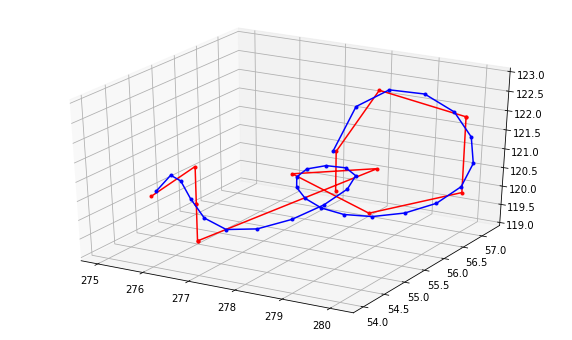

In [15]:
#%% Smooth trajectories
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage

L = LINKED[LINKED.PARTICLE == 5].values

num_true_pts = 2*len(L)


num_sample_pts = len(L)
x_sample = L[:, 0]
y_sample = L[:, 1]
z_sample = L[:, 2]

jump = np.sqrt(np.diff(x_sample)**2 + np.diff(y_sample)**2 + np.diff(z_sample)**2) 
smooth_jump = ndimage.gaussian_filter1d(jump, 5, mode='wrap')  # window of size 5 is arbitrary
limit = 2*np.median(smooth_jump)    # factor 2 is arbitrary
xn, yn, zn = x_sample[:-1], y_sample[:-1], z_sample[:-1]
xn = xn[(jump > 0) & (smooth_jump < limit)]
yn = yn[(jump > 0) & (smooth_jump < limit)]
zn = zn[(jump > 0) & (smooth_jump < limit)]
    
tck, u = interpolate.splprep([xn,yn,zn], s=1)
x_knots, y_knots, z_knots = interpolate.splev(tck[0], tck)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

fig2 = plt.figure(2)
ax3d = fig2.add_subplot(111, projection='3d')
ax3d.plot(x_sample, y_sample, z_sample, 'r.-')
# ax3d.plot(x_knots, y_knots, z_knots, 'g.')
ax3d.plot(x_fine, y_fine, z_fine, 'b.-')


In [ ]:
plt.subplot(3, 2, 1)
plt.plot(x_sample, '+')

plt.subplot(3, 2, 3)
plt.plot(y_sample, '+')

plt.subplot(3, 2, 5)
plt.plot(z_sample, '+')

plt.subplot(3, 2, 2)
plt.plot(xn, '+')

plt.subplot(3, 2, 4)
plt.plot(yn, '+')

plt.subplot(3, 2, 6)
plt.plot(zn, '+')